In [1]:
from pathlib import Path

import allensdk
import allensdk.brain_observatory.behavior.behavior_project_cache as bpc
import matplotlib.pyplot as plt
# import matplotlib as mpl
# increase dpi for all figures
plt.rcParams['figure.dpi'] = 300
import numpy as np
import pandas as pd
import pkg_resources
import seaborn as sns
import dtale
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys
from tqdm import tqdm

# pd.set_option('display.max_columns', 200)
print(
    "allensdk version 2.10.2 or higher is required, you have {} installed".format(
        pkg_resources.get_distribution("allensdk").version
    )
)

C:\ProgramData\Anaconda3\envs\visual_behavior_analysis\lib\site-packages\allensdk\brain_observatory\session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


allensdk version 2.10.2 or higher is required, you have 2.12.1 installed


In [2]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
# %matplotlib notebook
%matplotlib inline
# %matplotlib qt
# %matplotlib widget

### functions

In [4]:
def add_cell_type_column(df):
    """
    adds a column with abbreviated version of cre_line, i.e. Vip, Sst, Exc
    """
    cre_indices = df[df.cre_line == "Vip-IRES-Cre"].index.values
    df.loc[cre_indices, "cell_type"] = "Vip Inhibitory"

    cre_indices = df[df.cre_line == "Sst-IRES-Cre"].index.values
    df.loc[cre_indices, "cell_type"] = "Sst Inhibitory"

    cre_indices = df[df.cre_line == "Slc17a7-IRES2-Cre"].index.values
    df.loc[cre_indices, "cell_type"] = "Excitatory"

    return df

### cleaning the ophys_expriment_table

In [5]:
cache_dir = Path("G:/allensdk")
cache = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
experiments_table = cache.get_ophys_experiment_table()
cell_table = cache.get_ophys_cells_table()

experiments_table = add_cell_type_column(experiments_table)

print("ophys_experiment_table size = " + str(len(experiments_table)))

ophys_experiment_table size = 1941


In [172]:
dtale.show(experiments_table)

## select visual behavior & multiscope + only active sessions + remove duplicate sessions + remove inccorect passive tags 

In [174]:
print("VisualBehavior size = " + str(len(experiments_table[experiments_table.project_code == "VisualBehavior"])))

VisualBehavior size = 239


In [6]:
# remove duplicate sessions for mice and keep the last in visual behavior project code
no_dup_df = experiments_table[
    experiments_table.project_code == "VisualBehavior"
].drop_duplicates(subset=["mouse_id", "session_type"], keep="last")
print("VisualBehavior no duplicate size = " + str(len(no_dup_df)))

VisualBehavior no duplicate size = 212


In [175]:
print("VisualBehaviorMultiscope size = " + str(len(experiments_table[experiments_table.project_code == "VisualBehaviorMultiscope"])))

VisualBehaviorMultiscope size = 867


In [7]:
no_dup_multi = experiments_table[
    experiments_table.project_code == "VisualBehaviorMultiscope"
].drop_duplicates(
    subset=["mouse_id", "session_type", "imaging_depth", "targeted_structure"],
    keep="last",
)

print("VisualBehaviorMultiscope no duplicate size = " + str(len(no_dup_multi)))

VisualBehaviorMultiscope no duplicate size = 830


In [8]:
# concatnate VisualBehaviorMultiscope + VisualBehavior
experiment_df = pd.concat([no_dup_df, no_dup_multi])
len(experiment_df)

1042

In [9]:
# keep only active sessions where mice are engaged in the experiment
experiment_df = experiment_df[experiment_df.passive == False]
len(experiment_df)

728

In [10]:
# remove the 8 OPHYS_5_images_B_passive that have incorrect passive tags
experiment_df = experiment_df.drop(
    experiment_df[
        (experiment_df.session_type == "OPHYS_5_images_B_passive")
        | (experiment_df.session_type == "OPHYS_2_images_A_passive")
    ].index
)
len(experiment_df)

720

In [11]:
# drop ophys_4B experiments that don't meet the requirement of never seeing the images before
experiment_df = experiment_df.drop(experiment_df[(experiment_df.session_type=='OPHYS_4_images_B') & (experiment_df.prior_exposures_to_image_set
!= 0)].index)
len(experiment_df)

654

### to be able to differentiate different session types remove 1A that have more exposures thatn 3A. But should i do it??

In [12]:
# if 1A comes after 3A meaning that has higher exposures doesnt make sense

# only doing this for VisualBehavior
for mouse_id in experiment_df.mouse_id.unique():
    tmp = experiment_df[experiment_df.mouse_id == mouse_id]
    # print(tmp[tmp.index.values)
    # for visualbehavior
    if tmp.iloc[0].project_code == "VisualBehavior":
        if (
            tmp[
                tmp.session_type == "OPHYS_1_images_A"
            ].prior_exposures_to_image_set.values
            > tmp[
                tmp.session_type == "OPHYS_3_images_A"
            ].prior_exposures_to_image_set.values
        ):
            print("bad mouse_id with 1A>3A exposures = " + str(mouse_id))
            experiment_df = experiment_df.drop(
                tmp[tmp.session_type == "OPHYS_1_images_A"].index
            )
    # elif  tmp.iloc[0].project_code == 'VisualBehaviorMultiscope':

print(len(experiment_df))

# lest forget about multiscope for now i dont care for now 


# print(tmp[tmp.session_type == 'OPHYS_1_images_A'].date_of_acquisition)
# print(tmp.loc[tmp['session_type'] == 'OPHYS_1_images_A','date_of_acquisition'])
# if tmp[tmp.session_type == 'OPHYS_1_images_A'].date_of_acquisition > tmp[tmp.session_type == 'OPHYS_3_images_A'].date_of_acquisition:
#     print(mouse_id)
# if (tmp.iloc[0].project_code == 'VisualBehavior') and (tmp.iloc[0].session_type != 'OPHYS_1_images_A'):
#         print(tmp.index.values[0])


# # VisualBehaviorMultiscope
#     ses1a = tmp[tmp.session_type == 'OPHYS_1_images_A']
#     ses3a = tmp[tmp.session_type == 'OPHYS_3_images_A']
#     val1a = ses1a.prior_exposures_to_image_set.sum()
#     val3a = ses3a.prior_exposures_to_image_set.sum()
#     time_det = ses1a.
#     if val3a!=0:
#         # print(val1a,val3a)
#         if val1a>val3a:
#             index_list = np.append(index_list,ses1a.index.values)


# # index_list = np.int64(index_list)
# # print(index_list)

# # exp_logical = experiment_df.drop(index_list)
# # print(exp_logical)
# len(exp_logical)

bad mouse_id with 1A>3A exposures = 447663
bad mouse_id with 1A>3A exposures = 453913
652


## dtale

In [13]:
dtale.show(experiment_df)

In [14]:
# experiment_df.to_csv('cleaned-ophyexp_v1.csv')

### now let's have some basic count figures of our cleaned database

In [15]:
print('number of unique mouse id = '+ str(experiment_df.mouse_id.nunique()))

number of unique mouse id = 61


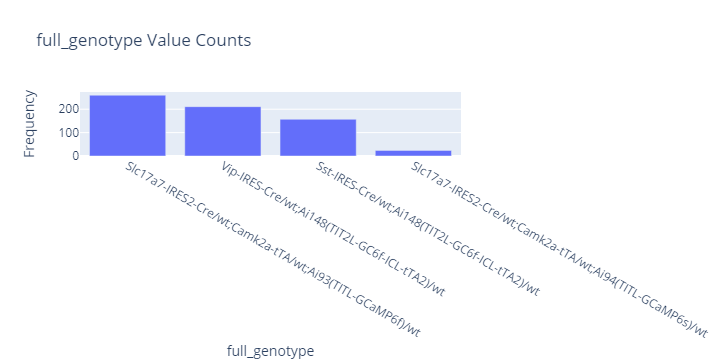

In [16]:
#full genotype value coounts

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['full_genotype'])]['full_genotype']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'full_genotype Value Counts'},
    'xaxis': {'title': {'text': 'full_genotype'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

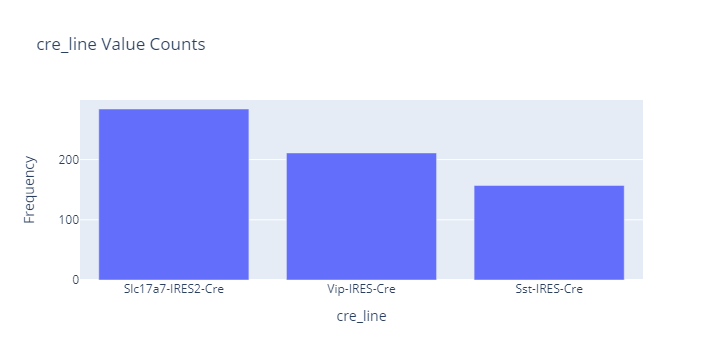

In [17]:
#creline counts

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['cre_line'])]['cre_line']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'cre_line Value Counts'},
    'xaxis': {'title': {'text': 'cre_line'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)
for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

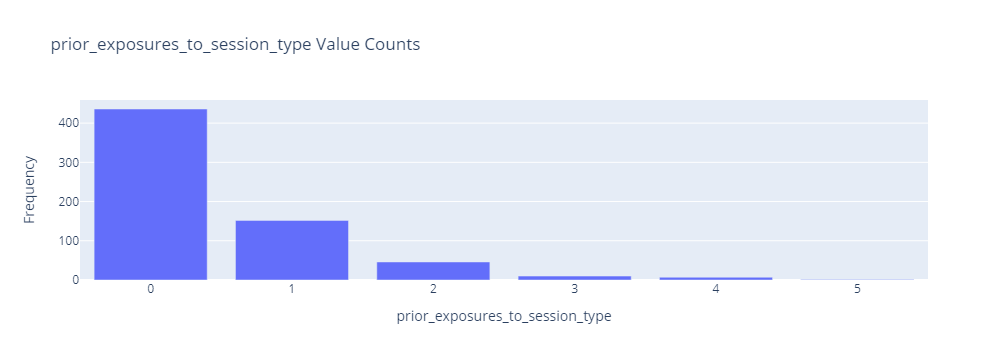

In [18]:
#prior_exposures_to_session_type

df = experiment_df.copy()

import numpy as np
import pandas as pd
import plotly.graph_objs as go

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['prior_exposures_to_session_type'])]['prior_exposures_to_session_type']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'prior_exposures_to_session_type Value Counts'},
    'xaxis': {'title': {'text': 'prior_exposures_to_session_type'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))

for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

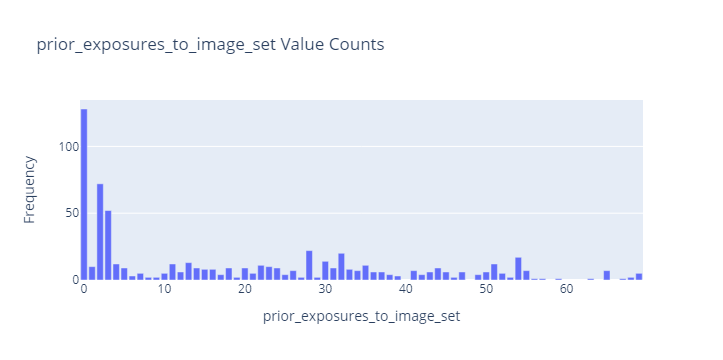

In [19]:
#prior_exposures_to_image_set


df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['prior_exposures_to_image_set'])]['prior_exposures_to_image_set']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'prior_exposures_to_image_set Value Counts'},
    'xaxis': {'title': {'text': 'prior_exposures_to_image_set'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))


for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

2022-05-27 01:03:53,522 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


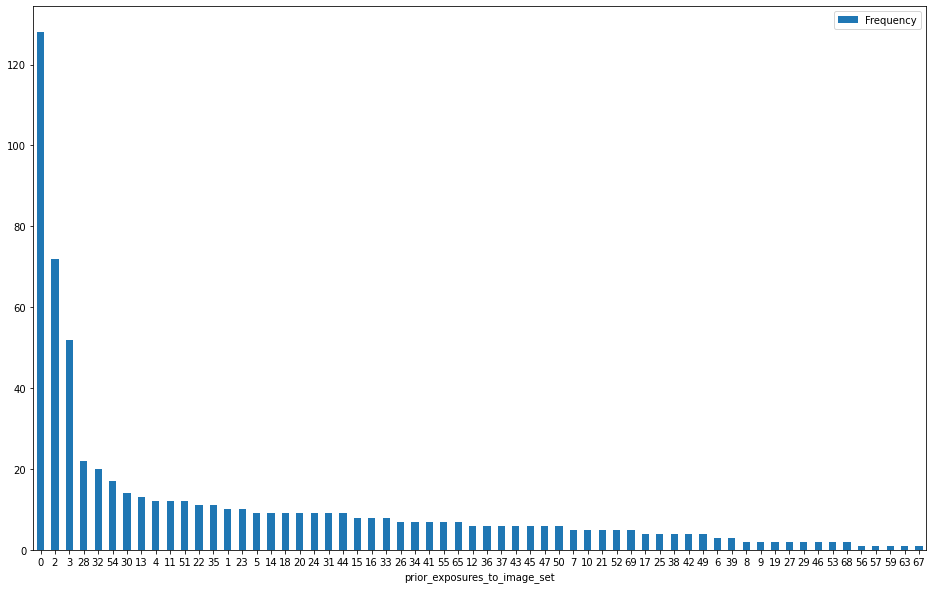

In [20]:

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['prior_exposures_to_image_set'])]['prior_exposures_to_image_set']
chart = pd.value_counts(s).to_frame(name='Frequency')
chart.index.name = 'prior_exposures_to_image_set'
chart = chart.reset_index().sort_values(['Frequency', 'prior_exposures_to_image_set'], ascending=[False, True])
chart['prior_exposures_to_image_set'] = chart['prior_exposures_to_image_set'].astype(int)
                                                                     
# chart = chart[:100]

# fig, ax = plt.subplots()
fig = chart.plot.bar(x='prior_exposures_to_image_set', y='Frequency', rot=0,figsize=(16,10))
# fig.tightlayout()

<!-- <img src='prior exposures to imageset.png'> -->


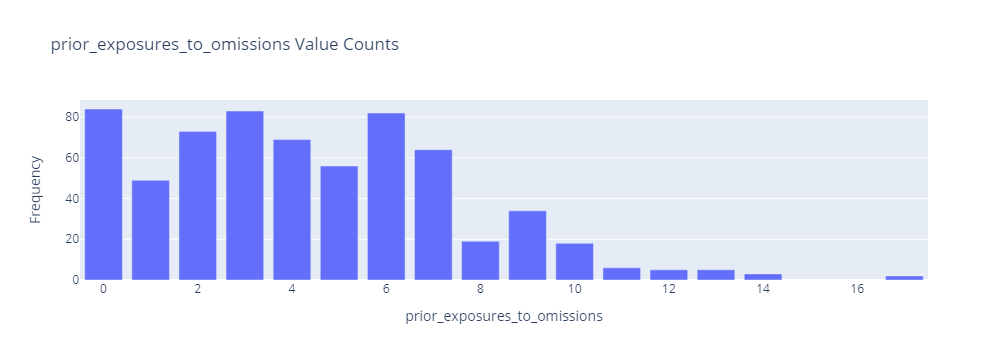

In [21]:
# prior_exposures_to_omissions

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['prior_exposures_to_omissions'])]['prior_exposures_to_omissions']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:10000]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'prior_exposures_to_omissions Value Counts'},
    'xaxis': {'title': {'text': 'prior_exposures_to_omissions'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))

for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

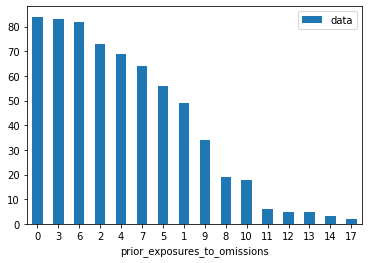

In [22]:


df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['prior_exposures_to_omissions'])]['prior_exposures_to_omissions']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'prior_exposures_to_omissions'
chart = chart.reset_index().sort_values(['data', 'prior_exposures_to_omissions'], ascending=[False, True])
chart['prior_exposures_to_omissions'] = chart['prior_exposures_to_omissions'].astype(int)
                          
ax = chart.plot.bar(x='prior_exposures_to_omissions', y='data', rot=0)
plt.show()

# how to sort the bars goddamit

        data
labels      
175      103
75        60
225       55
275       53
150       53
...      ...
93         1
174        1
281        1
261        1
95         1

[114 rows x 1 columns]
     labels  data
0       175   103
1        75    60
2       225    55
4       150    53
3       275    53
..      ...   ...
66      369     1
108     377     1
86      379     1
95      381     1
93      383     1

[114 rows x 2 columns]


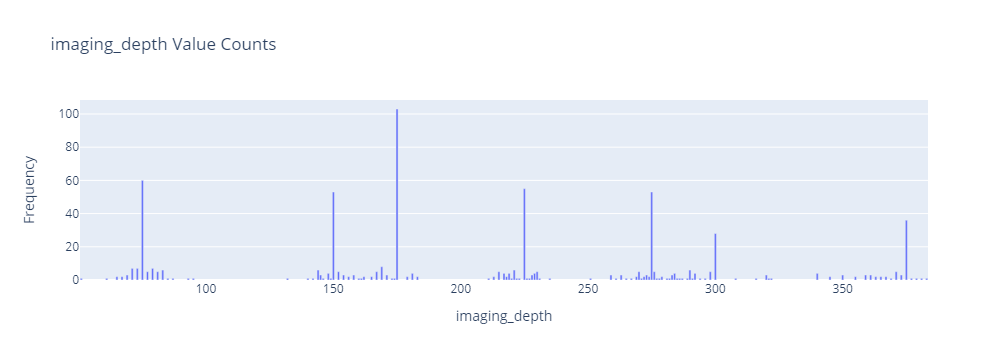

In [23]:

df = experiment_df.copy()


if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['imaging_depth'])]['imaging_depth']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
print(chart)
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
# chart = chart.reset_index()
print(chart)
# chart = chart[:100]


x = chart['labels'].to_numpy()
y = chart['data'].to_numpy()
lists = sorted(zip(*[x, y]))
new_x, new_y = list(zip(*lists))


# charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
charts = [go.Bar(x=chart['labels'], y=chart['data'], name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'imaging_depth Value Counts'},
    'xaxis': {'title': {'text': 'imaging_depth'}},
    'yaxis': {'title': {'text': 'Frequency'}},
}))


figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'imaging_depth Value Counts'},
    'xaxis': {'title': {'text': 'imaging_depth'}},
    'yaxis': {'title': {'text': 'Frequency'}},
}))

# for chart in charts:
#     chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

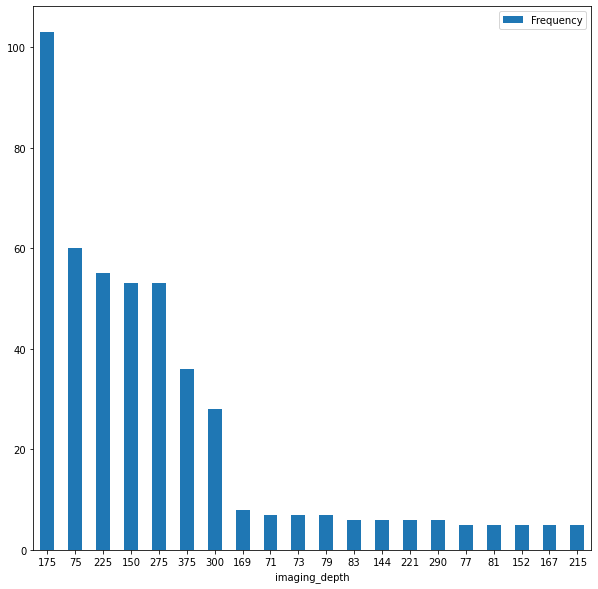

In [24]:
df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['imaging_depth'])]['imaging_depth']
chart = pd.value_counts(s).to_frame(name='Frequency')
chart.index.name = 'imaging_depth'
chart = chart.reset_index().sort_values(['Frequency', 'imaging_depth'], ascending=[False, True])
chart['imaging_depth'] = chart['imaging_depth'].astype(int)
# only showing first 20
chart = chart[:20]

ax = chart.plot.bar(x='imaging_depth', y='Frequency', rot=0,figsize=(10,10))
# fig.tight_layout()


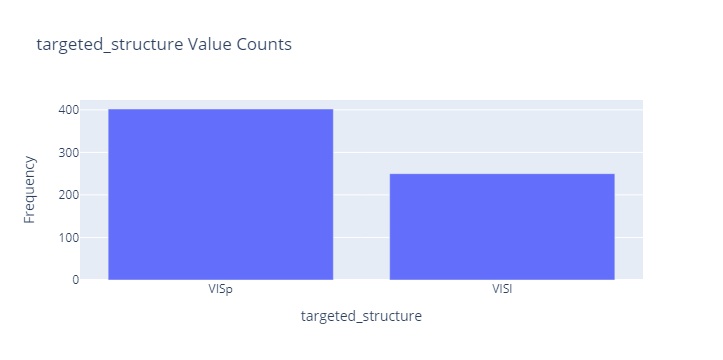

In [25]:
df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['targeted_structure'])]['targeted_structure']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'targeted_structure Value Counts'},
    'xaxis': {'title': {'text': 'targeted_structure'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))


for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

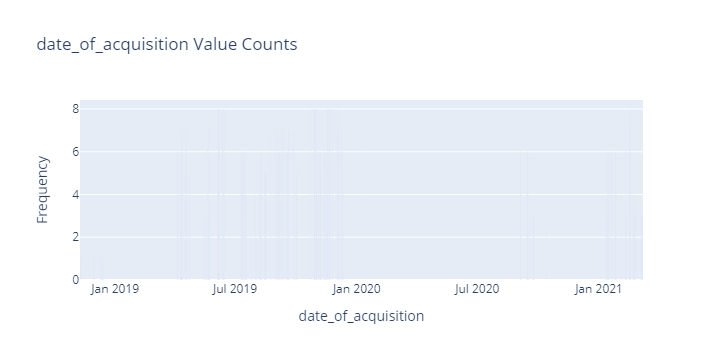

In [26]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = experiment_df.copy()


# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['date_of_acquisition'])]['date_of_acquisition']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'date_of_acquisition Value Counts'},
    'xaxis': {'title': {'text': 'date_of_acquisition'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))

for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

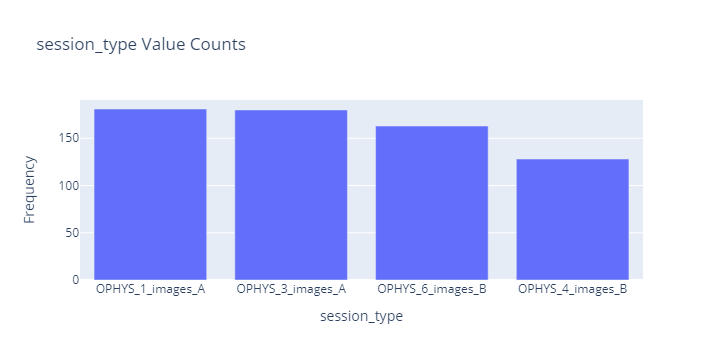

In [27]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['session_type'])]['session_type']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'session_type Value Counts'},
    'xaxis': {'title': {'text': 'session_type'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))


iplot(figure)

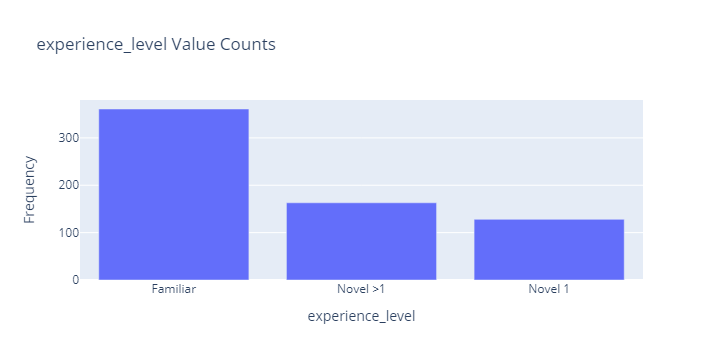

In [28]:
df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['experience_level'])]['experience_level']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'experience_level Value Counts'},
    'xaxis': {'title': {'text': 'experience_level'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))


iplot(figure)

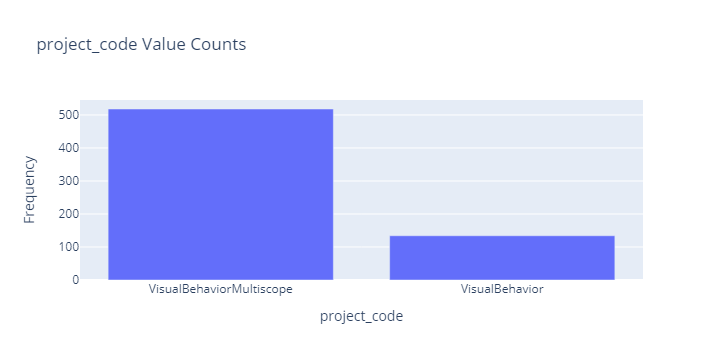

In [29]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = experiment_df.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['project_code'])]['project_code']
chart = pd.value_counts(s).to_frame(name='data')
chart.index.name = 'labels'
chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
chart = chart[:100]
charts = [go.Bar(x=chart['labels'].values, y=chart['data'].values, name='Frequency')]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'project_code Value Counts'},
    'xaxis': {'title': {'text': 'project_code'}},
    'yaxis': {'title': {'text': 'Frequency'}}
}))


iplot(figure)

## multiple feature analysis

In [30]:
all_expts = experiment_df.copy()
all_expts.groupby(['cell_type', 'experience_level', 'prior_exposures_to_image_set']).mean().reset_index().groupby(['cell_type', 'experience_level']).describe()[['prior_exposures_to_image_set']]

prior_exposures_to_image_set             \
                                                       count       mean   
cell_type      experience_level                                           
Excitatory     Familiar                                 36.0  31.722222   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  7.0   4.000000   
Sst Inhibitory Familiar                                 21.0  32.333333   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  3.0   3.333333   
Vip Inhibitory Familiar                                 25.0  33.000000   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  6.0   3.666667   

                                                                            
                                       std   min    25%   50%    75%   max  
cell_type      experience_level                                             
Excitatory     Familiar          16.470946   8.0  18.75  30.5  39.50  68.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           2.160247   1.0   2.50   4.0   5.50   7.0  
Sst Inhibitory Familiar          20.127924   9.0  17.00  27.0  43.00  69.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           1.527525   2.0   2.50   3.0   4.00   5.0  
Vip Inhibitory Familiar          16.350331  10.0  17.00  35.0  49.00  55.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           2.160247   1.0   2.25   3.5   4.75   7.0

In [87]:
tmp = experiment_df.copy()
# distrib_df = tmp.groupby(['cell_type', 'experience_level']).count()[['session_number']]
distrib_df = tmp.reset_index().groupby(['cell_type', 'experience_level']).count()[['ophys_experiment_id']]
distrib_df

ophys_experiment_id
cell_type      experience_level                     
Excitatory     Familiar                          161
               Novel 1                            58
               Novel >1                           65
Sst Inhibitory Familiar                           77
               Novel 1                            33
               Novel >1                           47
Vip Inhibitory Familiar                          123
               Novel 1                            37
               Novel >1                           51

<!-- cheting for now -->
<img src="bar_export_1653606527752.png" height="100"/>

# cell table

In [60]:
dtale.show(cell_table)

In [62]:
print('unique cell_specimen_id all =' + str(cell_table.cell_specimen_id.nunique()))

uniqe cell_specimen_id all =50489


In [63]:
print(len(cell_table))

133227


In [ ]:
# find cells that are only in our desired experiment 

In [68]:
selected_cell_table = cell_table.copy()

selected_cell_table = selected_cell_table.loc[selected_cell_table['ophys_experiment_id'].isin(experiment_df.index.values)]


In [70]:
print('unique cell_specimen_id all =' + str(selected_cell_table.cell_specimen_id.nunique()))

uniqe cell_specimen_id all =24661


In [ ]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = selected_cell_table.copy()
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['ophys_experiment_id'],
	df['cell_specimen_id'],
], axis=1)
chart_data = chart_data.sort_values(['ophys_experiment_id'])
chart_data = chart_data.rename(columns={'ophys_experiment_id': 'x'})
chart_data_count = chart_data.groupby(['x'])[['cell_specimen_id']].count()
chart_data_count.columns = ['cell_specimen_id|count']
chart_data = chart_data_count.reset_index()
chart_data = chart_data.dropna()
chart_data = chart_data.sort_values('cell_specimen_id|count', ascending=False).head(50)

import plotly.graph_objs as go

charts = []
charts.append(go.Bar(
	x=list(range(len(chart_data['x']))),
	y=chart_data['cell_specimen_id|count'],
	hovertext=chart_data['x'].values,
	hoverinfo='y_text'
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'stack',
    'legend': {'orientation': 'h'},
    'title': {'text': 'Count of cell_specimen_id by ophys_experiment_id'},
    'xaxis': {'nticks': 652, 'tickformat': '0:g', 'tickmode': 'auto', 'title': {'text': 'ophys_experiment_id'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'Count of cell_specimen_id'}, 'type': 'linear'}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
# from plotly.offline import iplot, init_notebook_mode
#
# init_notebook_mode(connected=True)
# for chart in charts:
#     chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(figure)

In [69]:
print(len(selected_cell_table))

48007


In [72]:
selected_cell_table.ophys_experiment_id.nunique()

652

In [ ]:
experiment_df.index.nunique()

652

In [113]:
dtale.show(selected_cell_table)
# import pandasgui
# show(selected_cell_table)

In [114]:
# selected_cell_table
# cell_distrib_df = selected_cell_table.reset_index().groupby(['cell_specimen_id','ophys_experiment_id']).count()
# cell_distrib_df

### choose experiments that have the most number of cells

In [155]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = selected_cell_table.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['ophys_experiment_id'],
	df['cell_specimen_id'],
], axis=1)
chart_data = chart_data.sort_values(['ophys_experiment_id'])
# chart_data = chart_data.rename(columns={'ophys_experiment_id': 'x'})
chart_data_count = chart_data.groupby(['ophys_experiment_id'])[['cell_specimen_id']].count()
chart_data_count.columns = ['cell_specimen_id|count']
chart_data = chart_data_count.reset_index()
chart_data = chart_data.dropna()
chart_data = chart_data.sort_values(by=['cell_specimen_id|count'],ascending=False)
chart_data = chart_data.sort_values('cell_specimen_id|count', ascending=False).head(50)


# charts = []
# charts.append(go.Bar(
# 	x=list(range(len(chart_data['x']))),
# 	y=chart_data['cell_specimen_id|count'],
# 	hovertext=chart_data['x'].values,
# 	hoverinfo='y+text'
# ))
# figure = go.Figure(data=charts, layout=go.Layout({
#     'barmode': 'group',
#     'legend': {'orientation': 'h'},
#     'title': {'text': 'Count of cell_specimen_id by ophys_experiment_id'},
#     'xaxis': {'nticks': 652, 'tickformat': '0:g', 'tickmode': 'auto', 'title': {'text': 'ophys_experiment_id'}},
#     'yaxis': {'tickformat': '0:g', 'title': {'text': 'Count of cell_specimen_id'}, 'type': 'linear'}
# }))
# figure.update_xaxes(tickangle=90)

# iplot(figure)

In [156]:
# dtale.show(chart_data)

In [157]:
chart_data.head(10)

,ophys_experiment_id,cell_specimen_id|count
128,877018118,666
116,873968820,604
37,845037476,556
132,878358326,556
422,977132456,555
352,956820482,549
38,846487947,537
403,974945686,517
164,884221469,516
385,972701564,511


In [165]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = selected_cell_table.copy()

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['cell_specimen_id'],
	df['ophys_experiment_id'],
], axis=1)
chart_data = chart_data.sort_values(['cell_specimen_id'])
chart_data = chart_data.rename(columns={'cell_specimen_id': 'x'})
chart_data_count = chart_data.groupby(['x'])[['ophys_experiment_id']].count()
chart_data_count.columns = ['ophys_experiment_id|count']
chart_data = chart_data_count.reset_index()
chart_data = chart_data.dropna()
chart_data = chart_data.sort_values('ophys_experiment_id|count', ascending=False).head(50)

# charts = []
# charts.append(go.Bar(
# 	x=list(range(len(chart_data['x']))),
# 	y=chart_data['ophys_experiment_id|count'],
# 	hovertext=chart_data['x'].values,
# 	hoverinfo='y+text'
# ))
# figure = go.Figure(data=charts, layout=go.Layout({
#     'barmode': 'group',
#     'legend': {'orientation': 'h'},
#     'title': {'text': 'Count of ophys_experiment_id by cell_specimen_id'},
#     'xaxis': {'nticks': 24661, 'tickformat': '0:g', 'tickmode': 'auto', 'title': {'text': 'cell_specimen_id'}},
#     'yaxis': {'tickformat': '0:g', 'title': {'text': 'Count of ophys_experiment_id'}, 'type': 'linear'}
# }))

# iplot(figure)

In [166]:
chart_data.tail(10)

,x,ophys_experiment_id|count
11699,1086579961,6
11722,1086580238,6
9815,1086562892,6
11756,1086580607,6
9531,1086560486,6
23617,1120118208,5
11808,1086581176,5
23910,1120121235,5
11243,1086575485,5
24367,1120131581,5


In [167]:
# dtale.show(chart_data)
len(chart_data)

50

In [168]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

df = chart_data.copy()

# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

df = df.rename(columns={'x': 'ophys_experiment_id'})
chart_data = pd.concat([
	df['ophys_experiment_id|count'],
	df['ophys_experiment_id'],
], axis=1)
chart_data = chart_data.sort_values(['ophys_experiment_id|count'])
chart_data = chart_data.rename(columns={'ophys_experiment_id|count': 'x'})
chart_data_count = chart_data.groupby(['x'])[['ophys_experiment_id']].count()
chart_data_count.columns = ['ophys_experiment_id|count']
chart_data = chart_data_count.reset_index()
chart_data = chart_data.dropna()

# import plotly.graph_objs as go

# charts = []
# charts.append(go.Bar(
# 	x=chart_data['x'],
# 	y=chart_data['ophys_experiment_id|count']
# ))
# figure = go.Figure(data=charts, layout=go.Layout({
#     'barmode': 'relative',
#     'legend': {'orientation': 'h'},
#     'title': {'text': 'Count of ophys_experiment_id by Count of ophys_experiment_id'},
#     'xaxis': {'tickformat': '0:g', 'title': {'text': 'Count of ophys_experiment_id'}},
#     'yaxis': {'tickformat': '0:g', 'title': {'text': 'Count of ophys_experiment_id'}, 'type': 'linear'}
# }))


# # iplot(figure)

Text(0.5, 0, 'number of experiments')

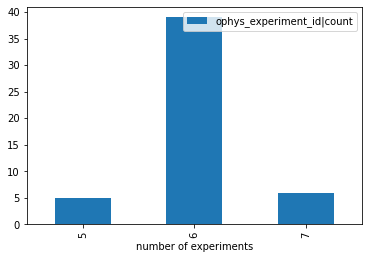

In [171]:
ax = chart_data.plot.bar(x='x', y= 'ophys_experiment_id|count')
ax.set_xlabel('number of experiments')
# this is not right 

In [127]:
# df = selected_cell_table.copy()

# if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
# 	df = df.to_frame(index=False)

# # remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
# df = df.reset_index().drop('index', axis=1, errors='ignore')
# df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

# chart_data = pd.concat([
# 	df['ophys_experiment_id'],
# 	df['cell_roi_id'],
# ], axis=1)
# chart_data = chart_data.sort_values(['ophys_experiment_id'])
# # chart_data = chart_data.rename(columns={'ophys_experiment_id': 'x'})
# chart_data_count = chart_data.groupby(['ophys_experiment_id'])[['cell_roi_id']].count()
# chart_data_count.columns = ['cell_roi_id|count']
# chart_data = chart_data_count.reset_index()
# chart_data = chart_data.dropna()
# chart_data = chart_data.sort_values(by=['cell_roi_id|count'],ascending=False)
# chart_data = chart_data.sort_values('cell_roi_id|count', ascending=False).head()

In [48]:
from pandasgui import show
show(chart_data)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
2022-05-27 01:27:05,160 - INFO     - Opening PandasGUI


In [125]:
# chart_data[:100].plot.bar(x='ophys_experiment_id',y = 'cell_specimen_id|count')